# Appling machine learning to audio analysis

## Trainning Code

### Libraries

In [1]:
### Dependencies were already installed previously on ubuntu
### Comet: experiment tracking and visual tools

from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa # audio analysis
import librosa.display # this submodule needs to be imported explicitly
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import os

In [2]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
# Keras now is fully integrated to Tensorflow, so to_categorical and Adam
# can't be imported directly from keras, therefore, the update:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

2022-01-06 20:52:32.578430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-06 20:52:32.578490: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# To play audio file:
import IPython.display as ipd

In [ ]:
# Create a Comet Experiment, to capture any and all artifacts
# such as audio files, visualization, model, dataset, system information and training metrics
experiment = Experiment(api_key = "Xa6eGiuYFngDcAJ9PVY1WpZp0", project_name = "SetA")

## MFCCs - Mel-Frequency Cepstrum Coefficients

### Function to extract the MFCCs from every file in our dataset

In [ ]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name) 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
     
    return mfccs_processed

In [ ]:
df = pd.read_csv('../csvFiles/newTiming.csv')

In [ ]:
from os.path import exists

In [ ]:
sounds = []# Iterate through each sound file and extract the sound type
cont = 0 #Conta os ficheiros que tiveram os MFCCs analizados
i = 0 # numero total de ficheiros

for index, row in df.iterrows():
    file_name = df.loc[index]['fname']
    class_label = df.loc[index]['sound']
    
    if 'noise' in class_label:
        class_label = 'noise'
    
    print(class_label)
    i+=1
    
    if (exists(file_name)):
        file_size = os.path.getsize(file_name)
        
        if (file_size > 44):
            data = extract_features(file_name)
            
            sounds.append([data, class_label])
            cont += 1
        else:
            print(file_name)
            
print(i, cont)
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(sounds, columns=['soundtype','class_label'])

In [ ]:
featuresdf
featuresdf.iloc[799]['class_label']
featuresdf.to_pickle('../MFCCs/cutA_toTrain.pkl') 

## Model building and training

### Load MFFCs from saved files

In [5]:
fileMFCCs = '../MFCCs/cutA_toTrain.pkl'
featuresdf = pd.read_pickle(fileMFCCs)

### Transform the data to arrays

In [6]:

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.soundtype.tolist())
y = np.array(featuresdf.class_label.tolist())


# Encode the classification labels
le = LabelEncoder()

yy = to_categorical(le.fit_transform(y))

### Trainning and test sets

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

### Neural Network architecture

In [8]:
keras.backend.clear_session()
num_labels = yy.shape[1]

filter_size = 2

def build_model_graph(input_shape=(40,)):
    model = Sequential()
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 
    
    return model

model = build_model_graph()

# Display model architecture summary 
model(x_train)
model.summary()# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

2022-01-06 20:52:47.637716: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-06 20:52:47.637785: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-06 20:52:47.637880: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (chico-VirtualBox): /proc/driver/nvidia/version does not exist
2022-01-06 20:52:47.638547: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (640, 512)                20992     
                                                                 
 activation (Activation)     (640, 512)                0         
                                                                 
 dropout (Dropout)           (640, 512)                0         
                                                                 
 dense_1 (Dense)             (640, 512)                262656    
                                                                 
 activation_1 (Activation)   (640, 512)                0         
                                                                 
 dropout_1 (Dropout)         (640, 512)                0         
                                                                 
 dense_2 (Dense)             (640, 512)                2

### Model Trainning

In [10]:
num_epochs = 300
num_batch_size = 32

csv_logger = keras.callbacks.CSVLogger('../model_save/cut_setA_Train_Hist_300.log')

model.fit(x_train, y_train, batch_size=num_batch_size,callbacks=[csv_logger], epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Epoch 1/300
20/20 [==============================] - 2s 30ms/step - loss: 24.0873 - accuracy: 0.4141 - val_loss: 2.8002 - val_accuracy: 0.5875
Epoch 2/300
20/20 [==============================] - 0s 23ms/step - loss: 13.6723 - accuracy: 0.4031 - val_loss: 4.5263 - val_accuracy: 0.6000
Epoch 3/300
20/20 [==============================] - 1s 30ms/step - loss: 7.1522 - accuracy: 0.4938 - val_loss: 0.9138 - val_accuracy: 0.6250
Epoch 4/300
20/20 [==============================] - 1s 29ms/step - loss: 5.8164 - accuracy: 0.4578 - val_loss: 0.7939 - val_accuracy: 0.6375
Epoch 5/300
20/20 [==============================] - 1s 28ms/step - loss: 3.2694 - accuracy: 0.5172 - val_loss: 0.7752 - val_accuracy: 0.6438
Epoch 6/300
20/20 [==============================] - 1s 26ms/step - loss: 3.3051 - accuracy: 0.4531 - val_loss: 0.8144 - val_accuracy: 0.6125
Epoch 7/300
20/20 [==============================] - 1s 32ms/step - loss: 2.2890 - accuracy: 0.5109 - val_loss: 0.7920 - val_accuracy: 0.7250
Epoc

20/20 [==============================] - 1s 27ms/step - loss: 0.7390 - accuracy: 0.6484 - val_loss: 0.7187 - val_accuracy: 0.7188
Epoch 59/300
20/20 [==============================] - 0s 24ms/step - loss: 0.7560 - accuracy: 0.6516 - val_loss: 0.6843 - val_accuracy: 0.7312
Epoch 60/300
20/20 [==============================] - 0s 23ms/step - loss: 0.7621 - accuracy: 0.6406 - val_loss: 0.6438 - val_accuracy: 0.7188
Epoch 61/300
20/20 [==============================] - 1s 27ms/step - loss: 0.7263 - accuracy: 0.6656 - val_loss: 0.6775 - val_accuracy: 0.7375
Epoch 62/300
20/20 [==============================] - 1s 30ms/step - loss: 0.7232 - accuracy: 0.6469 - val_loss: 0.6589 - val_accuracy: 0.7437
Epoch 63/300
20/20 [==============================] - 1s 30ms/step - loss: 0.7087 - accuracy: 0.6719 - val_loss: 0.6500 - val_accuracy: 0.7250
Epoch 64/300
20/20 [==============================] - 0s 24ms/step - loss: 0.7123 - accuracy: 0.6547 - val_loss: 0.6519 - val_accuracy: 0.6812
Epoch 65/300

20/20 [==============================] - 0s 22ms/step - loss: 0.5643 - accuracy: 0.7219 - val_loss: 0.5494 - val_accuracy: 0.7750
Epoch 116/300
20/20 [==============================] - 0s 24ms/step - loss: 0.5794 - accuracy: 0.6984 - val_loss: 0.5118 - val_accuracy: 0.7812
Epoch 117/300
20/20 [==============================] - 0s 25ms/step - loss: 0.5525 - accuracy: 0.7281 - val_loss: 0.5247 - val_accuracy: 0.7437
Epoch 118/300
20/20 [==============================] - 1s 25ms/step - loss: 0.5745 - accuracy: 0.7188 - val_loss: 0.5218 - val_accuracy: 0.7750
Epoch 119/300
20/20 [==============================] - 1s 25ms/step - loss: 0.5505 - accuracy: 0.7344 - val_loss: 0.5132 - val_accuracy: 0.7625
Epoch 120/300
20/20 [==============================] - 1s 30ms/step - loss: 0.5528 - accuracy: 0.7266 - val_loss: 0.5037 - val_accuracy: 0.8062
Epoch 121/300
20/20 [==============================] - 1s 30ms/step - loss: 0.5480 - accuracy: 0.7266 - val_loss: 0.5081 - val_accuracy: 0.7812
Epoch 

Epoch 172/300
20/20 [==============================] - 1s 29ms/step - loss: 0.5049 - accuracy: 0.7563 - val_loss: 0.4359 - val_accuracy: 0.7750
Epoch 173/300
20/20 [==============================] - 0s 24ms/step - loss: 0.4760 - accuracy: 0.7625 - val_loss: 0.4947 - val_accuracy: 0.7500
Epoch 174/300
20/20 [==============================] - 1s 28ms/step - loss: 0.4850 - accuracy: 0.7656 - val_loss: 0.4503 - val_accuracy: 0.8125
Epoch 175/300
20/20 [==============================] - 1s 25ms/step - loss: 0.4775 - accuracy: 0.7641 - val_loss: 0.4632 - val_accuracy: 0.7563
Epoch 176/300
20/20 [==============================] - 1s 33ms/step - loss: 0.5210 - accuracy: 0.7594 - val_loss: 0.4450 - val_accuracy: 0.8125
Epoch 177/300
20/20 [==============================] - 1s 32ms/step - loss: 0.4678 - accuracy: 0.7641 - val_loss: 0.4423 - val_accuracy: 0.8062
Epoch 178/300
20/20 [==============================] - 1s 32ms/step - loss: 0.4609 - accuracy: 0.7859 - val_loss: 0.4491 - val_accuracy:

Epoch 229/300
20/20 [==============================] - 1s 28ms/step - loss: 0.3822 - accuracy: 0.8031 - val_loss: 0.4682 - val_accuracy: 0.7875
Epoch 230/300
20/20 [==============================] - 1s 29ms/step - loss: 0.3768 - accuracy: 0.7953 - val_loss: 0.4980 - val_accuracy: 0.7937
Epoch 231/300
20/20 [==============================] - 1s 30ms/step - loss: 0.3701 - accuracy: 0.8391 - val_loss: 0.5059 - val_accuracy: 0.8000
Epoch 232/300
20/20 [==============================] - 0s 22ms/step - loss: 0.3741 - accuracy: 0.8219 - val_loss: 0.4504 - val_accuracy: 0.8313
Epoch 233/300
20/20 [==============================] - 1s 32ms/step - loss: 0.3803 - accuracy: 0.8219 - val_loss: 0.4730 - val_accuracy: 0.8125
Epoch 234/300
20/20 [==============================] - 0s 23ms/step - loss: 0.3757 - accuracy: 0.8141 - val_loss: 0.4998 - val_accuracy: 0.8125
Epoch 235/300
20/20 [==============================] - 0s 25ms/step - loss: 0.3797 - accuracy: 0.8094 - val_loss: 0.4828 - val_accuracy:

Epoch 286/300
20/20 [==============================] - 1s 26ms/step - loss: 0.3804 - accuracy: 0.8250 - val_loss: 0.5153 - val_accuracy: 0.8062
Epoch 287/300
20/20 [==============================] - 0s 24ms/step - loss: 0.3754 - accuracy: 0.8062 - val_loss: 0.4731 - val_accuracy: 0.8000
Epoch 288/300
20/20 [==============================] - 1s 29ms/step - loss: 0.3616 - accuracy: 0.8250 - val_loss: 0.5284 - val_accuracy: 0.7688
Epoch 289/300
20/20 [==============================] - 1s 31ms/step - loss: 0.3298 - accuracy: 0.8375 - val_loss: 0.4698 - val_accuracy: 0.8313
Epoch 290/300
20/20 [==============================] - 1s 25ms/step - loss: 0.3560 - accuracy: 0.8328 - val_loss: 0.5018 - val_accuracy: 0.8125
Epoch 291/300
20/20 [==============================] - 1s 27ms/step - loss: 0.3444 - accuracy: 0.8562 - val_loss: 0.6137 - val_accuracy: 0.7437
Epoch 292/300
20/20 [==============================] - 0s 25ms/step - loss: 0.3181 - accuracy: 0.8469 - val_loss: 0.5498 - val_accuracy:

In [11]:
model.save('../model_save/cut_setA', save_format='tf')

2022-01-06 20:56:44.906797: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../model_save/cut_setA/assets


### Plot of model performance

In [18]:
history = pd.read_csv('../model_save/cut_setA_Train_Hist_300.log')

Text(0, 0.5, 'Accuracy')

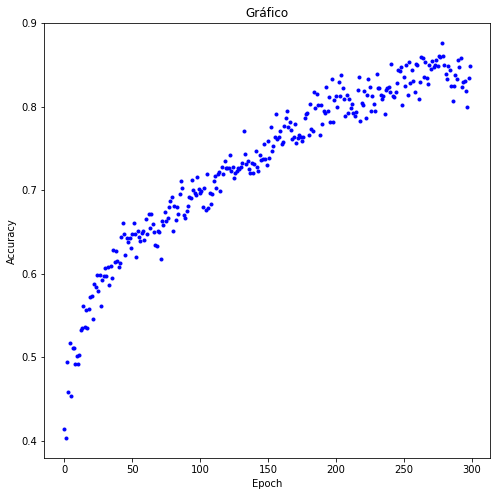

In [19]:
xx = np.array(history.epoch.tolist())
yy = np.array(history.accuracy.tolist())

fig = plt.figure(figsize=(8,8))
Plot = fig.add_subplot(111)

Plot.plot(xx, yy, "b.")

#Plot.axvline(x=Ei, c='red')
#Plot.axhline(y=npy.log(tauN), c='purple')

Plot.title.set_text("Gráfico")
Plot.set_xlabel("Epoch")
Plot.set_ylabel("Accuracy")


In [20]:
fig.savefig('../images/performance/300Epoch.jpg')

In [ ]:
experiment.end()